In [7]:
import tensorflow as tf
import numpy as np
import os,math,re,sys
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import tensorflow_addons as tfa
import matplotlib.pylab as plt
AUTO = tf.data.experimental.AUTOTUNE
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [2]:
IMG_SIZE = [224,224]
IMG_CHANNELS = 3
BATCH_SIZE = 32


def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3) #JPEG --> Tensor
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.reshape(image, [*IMG_SIZE, 3])
    image = tf.image.resize(image, IMG_SIZE) #image must be 3-D, so resize it
    return image

def read_tfrecord(example):
    image_feature_dict = {
        'image':tf.io.FixedLenFeature([],tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, image_feature_dict) #return a dict
    image = decode_image(example['image'])
    label = tf.cast(example['label'], tf.int64) - 1 #5 classes in[0,4]
    return image,label   #return a tuple

def load_dataset(filenames, ordered = False):
    ignore_order = tf.data.Options()

    if not ordered:
        ignore_order.deterministic = False # experimental_deterministic has been baned

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

def get_training_dataset():
    dataset = load_dataset('Training_Set.tfrecord') #ordered default is False
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) #Prepare later elements
    return dataset

def get_validation_dataset(ordered = False):
    dataset = load_dataset('Evaluation_Set.tfrecord', ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache() #cache files in memory
    dataset = dataset.prefetch(AUTO)
    return dataset

In [3]:
print("Training data shapes:")
for image, label in get_training_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training label examples:", label.numpy())
labelarray = label.numpy()
print(labelarray[0],type(labelarray[0]))
imagearray = image.numpy()
print(imagearray[0], type(imagearray[0]))

Training data shapes:


2022-04-14 11:32:01.553587: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Training label examples: [3 0 2 1 0 3 3 4 0 1 2 1 4 4 0 1 1 0 0 3 2 3 4 4 0 1 3 1 2 2 2 2]
3 <class 'numpy.int64'>
[[[0.39982748 0.5213961  0.22335686]
  [0.39611349 0.5172619  0.22006305]
  [0.39541948 0.5130665  0.22287041]
  ...
  [0.45580602 0.41377676 0.25693652]
  [0.46567878 0.41175726 0.26543367]
  [0.44730034 0.38494167 0.24366012]]

 [[0.39642859 0.51768214 0.21974792]
  [0.40023264 0.5210772  0.22397211]
  [0.40040144 0.5178759  0.22767983]
  ...
  [0.38324448 0.35594735 0.20166187]
  [0.40086406 0.36330655 0.22068197]
  [0.3946742  0.34525824 0.20755188]]

 [[0.40440553 0.51387185 0.21992299]
  [0.40885857 0.51862496 0.22494625]
  [0.41519237 0.5260467  0.23599441]
  ...
  [0.3117646  0.30602235 0.15410031]
  [0.33347332 0.3266431  0.17739712]
  [0.33120376 0.32474867 0.17573532]]

 ...

 [[0.24942358 0.35178578 0.24610716]
  [0.21205851 0.32531518 0.21566755]
  [0.21171471 0.32814756 0.21767461]
  ...


(20, 224, 224, 3) (20,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0 3 4 3 3 3 4 2 4 3 2 0 3 4 2 2 0 0 0 3]


(-0.5, 223.5, 223.5, -0.5)

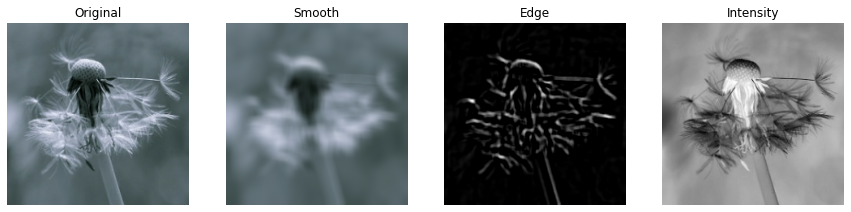

In [13]:
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20) #20 images, 20 labels in every batch 
train_batch = iter(training_dataset)

for image, label in train_batch:
    print(image.numpy().shape, label.numpy().shape)
    print(type(image.numpy()), type(label.numpy()))
    print(label.numpy())
    break
    
image_batch, label_batch = next(train_batch) # accept the first batch
label_batch = label_batch.numpy()

plt.figure(figsize=(15, 5)) #the size of whole figure

ax = plt.subplot(1, 4, 1) #the whole figure has 1 rows, 4 columns figures, this is 1 figure
img = image_batch[0]

plt.imshow(img.numpy())
plt.title('Original')
plt.axis("off")

mean = tfa.image.mean_filter2d(img, filter_shape=11)
ax = plt.subplot(1, 4, 2) #the whole figure has 1 rows, 4 columns figures, this is 2 figure
plt.imshow(mean.numpy())
plt.title('Smooth')
plt.axis("off")


edge = tf.clip_by_value(tf.image.rgb_to_grayscale(
    tfa.image.mean_filter2d(img, filter_shape=5) - tfa.image.mean_filter2d(img, filter_shape=11)
), 0, 1)
ax = plt.subplot(1, 4, 3) #the whole figure has 1 rows, 4 columns figures, this is 3 figure
plt.imshow(edge.numpy(), cmap='gray')
plt.title('Edge')
plt.axis("off")


bw_img = 1.0 - tf.image.rgb_to_grayscale(img)
ax = plt.subplot(1, 4, 4) #the whole figure has 1 rows, 4 columns figures, this is 4 figure
plt.imshow(bw_img.numpy(), cmap='gray')
plt.title('Intensity')
plt.axis("off")